# CSE 252A (Computer Vision I)  ·  Fall 2020  ·  Assignment 3

---

### Instructor: David Kriegman
### Assignment published on Sunday, November 15, 2020
### Due on Sunday, November 29, 2020 at 11:59 pm Pacific Time

---

## Instructions

* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains theoretical and programming exercises. If you plan to submit handwritten answers for the theoretical exercises, please be sure that your writing is readable (illegible answers will not be given the benefit of the doubt!) and merge your handwritten solutions in problem order with the PDF that you create from this notebook. You can also write the answers within the notebook itself by creating Markdown cells.
* Programming aspects of this assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you can do so. The existing code is merely meant to provide you with a framework for your solution.
* You may use Python packages for basic linear algebra (you can use NumPy or SciPy for basic operations), but you may not use packages that directly solve the problem.
* If you are unsure about using a specific package or function, then ask the instructor and teaching assistants for clarification.
* You must submit to Gradescope: 
    * (1) This notebook exported as a `.pdf` file (including any handwritten solutions scanned and merged into the PDF, if applicable).
    * (2) This notebook as an `.ipynb` file. 
* You must select the pages associated with each problem on Gradescope (for your PDF submission).
* **Late policy:** Assignments submitted late will receive a 10% grade reduction for each day late (e.g. an assignment submitted an hour after the due date will receive a 10% penalty, an assignment submitted 10 hours after the due date will receive a 10% penalty, and an assignment submitted 28 hours after the due date will receive a 20% penalty). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only), you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances.

## Problem 1: Edge Detection (11 points)

In this problem, you will write a function to perform Canny edge detection. The following steps need to be implemented.

- **Smoothing [1 pt]:** First, we need to smooth the images in order to prevent noise from being considered as edges. For this assignment, use a 5x5 Gaussian kernel filter with $\sigma = 1.4$ to smooth the images.

- **Gradient Computation [2 pts]:** After you have finished smoothing, find the image gradient in the horizontal and vertical directions. Compute the gradient magnitude image as $|G| = \sqrt{G_x^2 + G_y^2}$. The edge direction for each pixel is given by $G_\theta = \tan^{-1}\left(\frac{G_y}{G_x}\right)$.

- **Non-Maximum Suppression [4 pts]:** We would like our edges to be sharp, unlike the ones in the gradient image. Use non-maximum suppression to preserve all local maxima and discard the rest. You can use the following method to do so:

  - For each pixel in the gradient magnitude image:
    - Round the gradient direction $\theta$ to the nearest multiple of $45^{\circ}$ (which we will refer to as $ve$).
    - Compare the edge strength at the current pixel to the pixels along the $+ve$ and $-ve$ gradient direction in the 8-connected neighborhood.
    - If the pixel does not have a larger value than both of its two neighbors in the $+ve$ and $-ve$ gradient directions, suppress the pixel's value (set it to 0). By following this process, we preserve the values of only those pixels which have maximum gradient magnitudes in the neighborhood along the $+ve$ and $-ve$ gradient directions.
  - Return the result as the NMS response.

- **Hysteresis Thresholding [4 pts]:** If we use NMS output as a mask to detect edges i.e. `nms_edges = nms > 0; plt.imshow(nms_edges)`, we see that too many edges (including many stray edges) are discovered. To circumvent this, choose suitable values of thresholds and apply the hysteresis thresholding approach described in lecture. This will remove the edges caused by noise and color variations. The following algorithm might be helpful:

  - Define two thresholds `t_min` and `t_max`.
  - If the `nms > t_max`, then we select that pixel as an edge.
  - If `nms < t_min`, we reject that pixel.
  - If `t_min < nms < t_max`, we select the pixel only if there is a path from to another pixel with `nms > t_max`. (Hint: Think of all pixels with `nms > t_max` as starting points and run BFS from these starting points).

Compute the images after each step and select suitable thresholds that retain most of the true edges. As depicted in the example below, show each of the intermediate steps and label your images accordingly.

In total, there should be five output images (original, smoothed, gradient magnitude, NMS edges, final edges).

**For this question, use the image `sio_pier.jpg`.**

<img src="fig/edge_detection_example.png" alt="edge detection example" width="600px"/>

In the figure above: (a) Smoothed image , (b) Gradient magnitude , (c) NMS edges , (d) Final edges after
thresholding

Original:


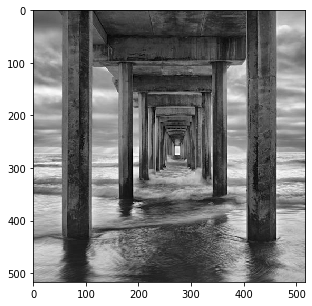

Smoothed:


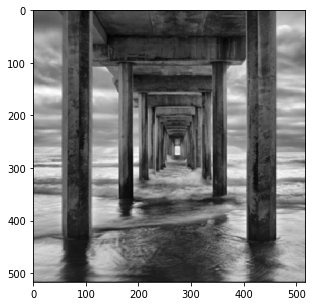

Gradient magnitude:


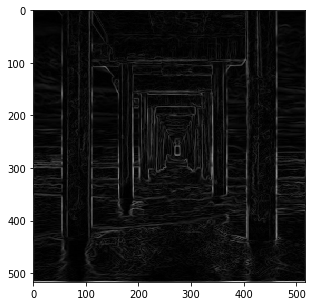

NMS:


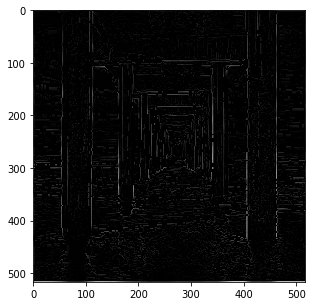

Hysteresis Thresholded:


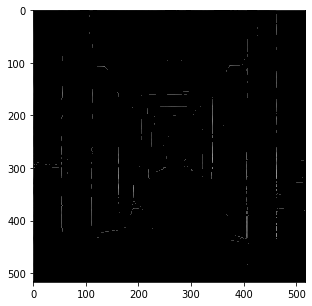

In [8]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import convolve
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 5]

def gaussian2d(filter_size=5, sig=1.0):
    """Creates a 2D Gaussian kernel with
    side length `filter_size` and a sigma of `sig`."""
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

def smooth(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    image = convolve(image, gaussian2d(), mode='same')
    return image

def gradient(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    g_mag = np.zeros_like(image)
    g_theta = np.zeros_like(image)
    
    kh = np.array([[1,0,-1]])
    kv = np.array([[1],[0],[-1]])
    
    gX = convolve(image, kh, mode = 'same')
    gY = convolve(image, kv, mode = 'same')
    
    g_mag = abs(np.sqrt( np.square(gX) + np.square(gY) ))
    g_theta = (180/np.pi)*np.arctan(gY/gX)
    return g_mag, g_theta

def nms(g_mag, g_theta):
    """ ==========
    YOUR CODE HERE
    ========== """
    nms_response = np.array(g_mag)
    g_theta[(-22.5 <= g_theta) & (22.5 > g_theta)] = 0
    g_theta[(-67.5 <= g_theta) & (-22.5 > g_theta)] = -45
    g_theta[(67.5 > g_theta) & (22.5 <= g_theta)] = 45
    g_theta[-67.5 > g_theta] = 90
    g_theta[67.5 <= g_theta] = 90
    
    sz = np.shape(nms_response)
    pixel1,pixel2 = 0,0
    for i in range(1, sz[0]-2):
        for j in range(1,sz[1]-2):
            #get gradient direction to pick comparison pixels
           if g_theta[i,j] == 90:
               pixel1 = nms_response[i-1,j]
               pixel2 = nms_response[i+1,j]
           elif g_theta[i,j] == -45:
               pixel1 = nms_response[i-1,j-1]
               pixel2 = nms_response[i+1,j+1]
           elif g_theta[i,j] == 0:
               pixel1 = nms_response[i,j+1]
               pixel2 = nms_response[i,j-1]
           elif g_theta[i,j] == 45:
               pixel1 = nms_response[i-1,j+1]
               pixel2 = nms_response[i+1,j-1]
           else:
               print("ERROR!!")
           if (nms_response[i,j] >= pixel1) & (nms_response[i,j] >= pixel2):
               nothing=0
           else:
               nms_response[i,j]=0
    return nms_response

def hysteresis_threshold(image, g_theta):
    """ ==========
    YOUR CODE HERE
    ========== """
    threshImage = np.array(image)
    def checkPoint(x, y):
        x1,y1,x2,y2 = 0,0,0,0
        if g_theta[x,y] == 90:
            x1,y1 = x,y-1
            x2,y2 = x,y+1
        elif g_theta[x,y] == -45:
            x1,y1 = x-1,y+1
            x2,y2 = x+1,y-1
        elif g_theta[x,y] == 0:
            x1,y1 = x+1,y
            x2,y2 = x-1,y
        elif g_theta[x,y] == 45:
            x1,y1 = x-1,y-1
            x2,y2 = x+1,y+1
        else:
            print("ERROR!!")
        if (threshImage[x1,y1] > t_min) & (threshImage[x1,y1] < t_max):
            start_pts[x1,y1] = edgePoint
            threshImage[x1,y1] = edgePoint
            checkPoint(x1, y1)
            
        if (threshImage[x2,y2] > t_min) & (threshImage[x2,y2] < t_max):
            start_pts[x2,y2] = edgePoint
            threshImage[x2,y2] = edgePoint
            checkPoint(x2, y2)
        return
    
    t_min = .01
    t_max = .2
    edgePoint = 1.0
    sz = np.shape(threshImage)
    start_pts = np.zeros((sz[0],sz[1]))
    for i in range(0, sz[0]-1):
        for j in range(0,sz[1]-1):
            if threshImage[i,j] >= t_max:
                start_pts[i,j] = edgePoint
    result = start_pts*image
    return result

def edge_detect(image):
    """Perform edge detection on the image."""
    smoothed = smooth(image)
    g_mag, g_theta = gradient(smoothed)
    nms_image = nms(g_mag, g_theta)
    thresholded = hysteresis_threshold(nms_image, g_theta)
    return smoothed, g_mag, nms_image, thresholded

# Load image in grayscale
image = io.imread('sio_pier.jpg', as_gray=True)
assert len(image.shape) == 2, 'image should be grayscale; check your Python/skimage versions'

# Perform edge detection
smoothed, g_mag, nms_image, thresholded = edge_detect(image)

print('Original:')
plt.imshow(image, cmap=cm.gray)
plt.show()

print('Smoothed:')
plt.imshow(smoothed, cmap=cm.gray)
plt.show()

print('Gradient magnitude:')
plt.imshow(g_mag, cmap=cm.gray)
plt.show()

print('NMS:')
plt.imshow(nms_image, cmap=cm.gray)
plt.show()

print('Hysteresis Thresholded:')
plt.imshow(thresholded, cmap=cm.gray)
plt.show()


## Problem 2: Epipolar Geometry (6 points)

Consider two cameras whose image planes are the z=1 plane, and whose focal points are at (-12, 0, 0) and (12, 0, 0). We'll call a point in the first camera (x, y), and a point in the second camera (u, v). Points in each camera are relative to the camera center. So, for example if (x, y) = (0, 0), this is really the point (-12, 0, 1) in world coordinates, while if (u, v) = (0, 0) this is the point (12, 0, 1).
![fig1](fig/fig1.png)

a) Suppose the point (x, y) = (15, 2) is matched to the point (u, v) = (1, 2). What is the 3D location of this point?

b) Consider points that lie on the line x + z = 0, y = 0. Use the same stereo set up as before. Write an analytic expression giving the disparity of a point on this line after it projects onto the two images, as a function of its position in the right image. So your expression should only involve the variables u and d (for disparity). Your expression only needs to be valid for points on the line that are in front of the cameras, i.e. with z > 1.

## Problem 3: The Epipolar Constraint (4 points)

Suppose two cameras fixate on a point $P$ in space such that their principal axes intersect at that point. (See the figure below.) Show that if the image coordinates are normalized so that the coordinate origin (0, 0) coincides with the principal point, then the $F_{33}$ element of the fundamental matrix is zero.

![fig1](fig/ec_diagram.png)

In the figure, $C1$ and $C2$ are the optical centers. The principal axes intersect at point $P$.

## Problem 4: Sparse Stereo Matching (32 points)

In this problem we will play around with sparse stereo matching methods. You will work on two image pairs: a warrior figure and a figure from the "Matrix" movies. Each file contains two images, two camera matrices, and two sets of corresponding points (extracted by manually clicking the images). For illustration, we have run our code on a third image pair (`dino1.png`, `dino2.png`). This data is also provided for you to debug your code, but **you should only report results for `warrior` and `matrix`**. In other words, where we include one (or a pair) of images in the assignment below, you will provide the same thing but for BOTH `warrior` and `matrix`. Note that the `matrix` image pair is harder, in the sense that the matching algorithms we are implementing will not work quite as well. You should expect good results, however, on `warrior`.

### Corner Detection (8 points)

The first thing we need to do is to build a corner detector. This should be done according to the lecture slides. You should fill in the function <code>corner_detect</code> below, which takes as input <code>image, nCorners, smoothSTD, windowSize</code> -- where `smoothSTD` is the standard deviation of the smoothing kernel and `windowSize` is the window size for corner detector and non-maximum suppression. In the lecture, the corner detector was implemented using a hard threshold. Do not do that; instead, return the `nCorners` strongest corners after non-maximum suppression. This way you can control exactly how many corners are returned. Run your code on all four images (with `nCorners` = 20) and display outputs as shown below.

Note 1: careful with your padding! Be aware that zero padding can affect whether corners are detected around the borders of the image, i.e. you might end up with false corners because of large discontinuities between these artificial black regions and the actual image content. To avoid this happening, feel free to ignore `windowSize // 2` pixels on all sides of the image when considering candidate locations for corners, or to try using symmetric padding.

Note 2: you are allowed to use `scipy.signal.convolve`, `scipy.ndimage.maximum_filter`, `np.pad`, and `scipy.ndimage.filters.gaussian_filter` for this problem.

In this problem, try the following different standard deviation ($\sigma$) parameters for the Gausian smoothing kernel: 0.5, 1, 2 and 4. For a particular $\sigma$, you should take the kernel size to be $6\times\sigma$ (add $1$ if the kernel size is even). So for example if $\sigma=2$, corner detection kernel size should be $13$. This should be followed throughout all of the experiments in this assignment.

There will be a total of 16 images as outputs: 4 choices of `smoothSTD` x 2 `matrix` images x 2 `warrior` images.

![dinoCorner1](fig/dinoCorner1.png)
![dinoCorner2](fig/dinoCorner2.png)

Comment on your results and observations (3/8 points). You don't need to comment per output; just **discuss** any trends you see for the detected corners as you change the `windowSize` and increase the smoothing w.r.t the two pairs of images (`warrior` and `matrix`). Also discuss whether you are able to find corresponding corners for the pairs of images.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import maximum_filter
import imageio
from scipy.signal import convolve
from numpy.linalg import eig

def gaussian2d(filter_size=5, sig=1.0):
    """Creates a 2D Gaussian kernel with
    side length `filter_size` and a sigma of `sig`."""
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)
def smooth(image, sigma):
    """ ==========
    YOUR CODE HERE
    ========== """
    fltr = gaussian2d(filter_size=6*sigma, sig=sigma)
    image = convolve(image, fltr, mode='same')
    return image
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def gradient(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    g_mag = np.zeros_like(image)
    g_theta = np.zeros_like(image)
    kh = np.array([[1,0,-1]])
    kv = np.array([[1],[0],[-1]])
    gX = convolve(image, kh, mode = 'same')
    gY = convolve(image, kv, mode = 'same')
    gX[:,0] = gX[:,1]
    gY[0,:] = gY[1,:]
    return gX, gY

In [82]:
def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.
    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for corner detector and non-maximum suppression.
    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).
    """
    corners = np.zeros((nCorners, 2))
    rXY = np.zeros_like(image)
    smoothedImage = gaussian_filter(image, smoothSTD)
    gX, gY = gradient(smoothedImage)
    sz = np.shape(smoothedImage)
    sub = windowSize//2
    add = windowSize//2
    
    for i in range(sub, sz[0]-1-add ):
        for j in range(sub, sz[1]-1-add ):
            c = np.zeros((2,2))
            if windowSize%2 == 0:
                wX = np.array(gX[i-sub:i+add, j-sub:j+add])
                wY = np.array(gY[i-sub:i+add, j-sub:j+add])
            else:
                wX = np.array(gX[i-sub:i+add+1, j-sub:j+add+1])
                wY = np.array(gY[i-sub:i+add+1, j-sub:j+add+1])
            
            c[0,0] = np.sum(wX*wX)
            c[0,1] = np.sum(wX*wY)
            c[1,0] = np.sum(wX*wY)
            c[1,1] = np.sum(wY*wY)
            values, vectors = eig(c)
            rXY[i,j] = min(values)
    #plt.imshow(rXY)
    #plt.show()
    
    
    nms_rXY = np.zeros_like(rXY)
    for i in range(sub, sz[0]-1-add ):
        for j in range(sub, sz[1]-1-add ):
            if windowSize%2 == 0:
                window = np.array(rXY[i-sub:i+add, j-sub:j+add])
            else:
                window = np.array(rXY[i-sub:i+add+1, j-sub:j+add+1])
            mx = np.max(window)
            if rXY[i,j] == mx :
                nms_rXY[i,j] = rXY[i,j]
    
    #plt.imshow(nms_rXY)
    #plt.show()
    
    for c in range(0,nCorners):
        result = np.where(nms_rXY == np.amax(nms_rXY))
        i = result[0][0]
        j = result[1][0]
        corners[c,0]=j
        corners[c,1]=i
        nms_rXY[i,j] =0
    a=1
    return corners

smooth stdev: 0.5
window size: 3


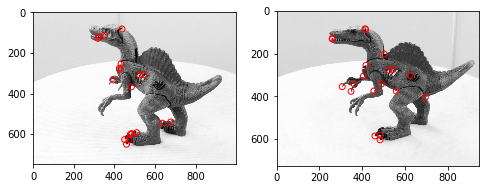

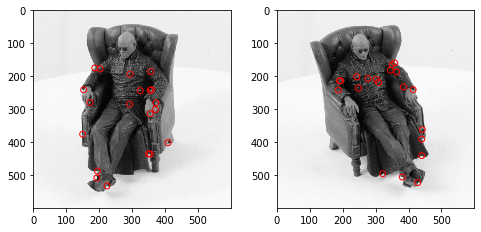

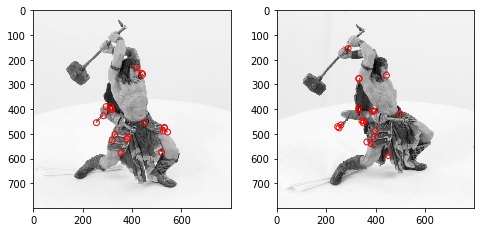

smooth stdev: 1
window size: 7


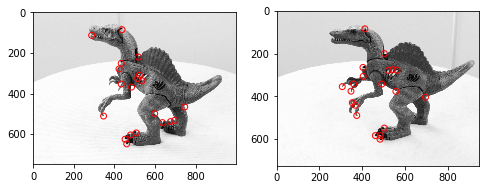

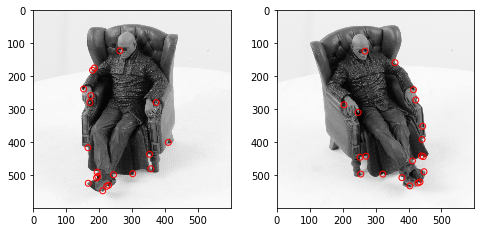

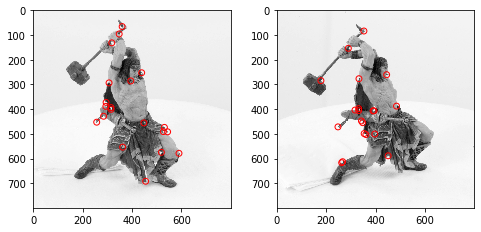

smooth stdev: 2
window size: 13


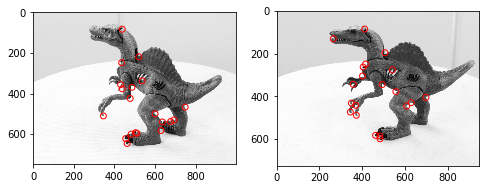

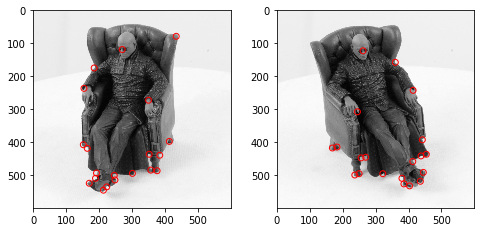

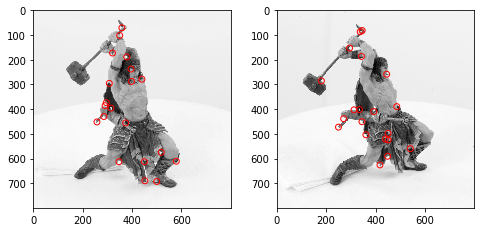

smooth stdev: 4
window size: 25


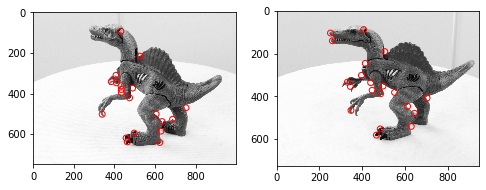

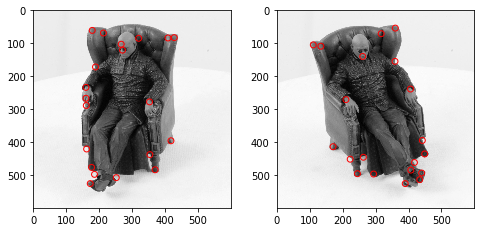

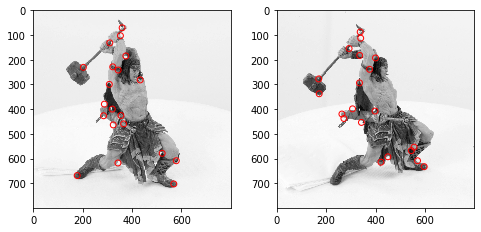

In [83]:
def show_corners_result(imgs, corners):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=35, edgecolors='r', facecolors='none')

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.show()
    
for smoothSTD in (0.5, 1, 2, 4):
    windowSize = int(smoothSTD * 6)
    if windowSize % 2 == 0:
        windowSize += 1
        
    print('smooth stdev: %r' % smoothSTD)
    print('window size: %r' % windowSize)

    nCorners = 20

    # read images and detect corners on images      
    
    imgs_din = []
    crns_din = []
    imgs_mat = []
    crns_mat = []
    imgs_war = []
    crns_war = []
    
    downSize = 2
    
    for i in range(2):
        img_din = imageio.imread('p4/dino/dino' + str(i) + '.png')
        #imgs_din.append(rgb2gray(img_din))
        # downsize your image in case corner_detect runs slow in test
        imgs_din.append(rgb2gray(img_din)[::downSize, ::downSize])
        crns_din.append(corner_detect(imgs_din[i], nCorners, smoothSTD, windowSize))

        img_mat = imageio.imread('p4/matrix/matrix' + str(i) + '.png')
        #imgs_mat.append(rgb2gray(img_mat))
        # downsize your image in case corner_detect runs slow in test
        imgs_mat.append(rgb2gray(img_mat)[::downSize, ::downSize])
        crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))

        img_war = imageio.imread('p4/warrior/warrior' + str(i) + '.png')
        #imgs_war.append(rgb2gray(img_war))
        # downsize your image in case corner_detect runs slow in test
        imgs_war.append(rgb2gray(img_war)[::downSize, ::downSize])
        crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))

    show_corners_result(imgs_din, crns_din)
    show_corners_result(imgs_mat, crns_mat)
    show_corners_result(imgs_war, crns_war)

Comment on your results and observations (3/8 points). You don't need to comment per output; just discuss any trends you see for the detected corners as you change the windowSize and increase the smoothing w.r.t the two pairs of images (warrior and matrix). Also discuss whether you are able to find corresponding corners for the pairs of images.

With a larger smoothing standard deviation and thus a larger window, the corner_detect function tends to pick up corners better. On matrix, with a small standard deviation and window, there is a large amount of corners on the clothing of the man, which makes sense because a sharp image an small window will favor small details as corners. As the standard deviation and window size grows on matrix, the corners become more distributed around the man, which is desired as those are what humans visually see as corners in an image, rather an area of high detail with a large gradient, which is what is detected with a small standard deviation. On warrior, it is similarly observed that a small standard deviation and window size tends to result in corners being placed on the clothing, (not desired), while as the standard deviation and window get larger, the corners are moved toward to the toes, the satchel, and the weapon, which visually look more like corners in the image. This occurs for the same reason explained above for matrix.

Corresponding corners on images can be found for all standard deviation and window sizes on both matrix and warrior. The corners shift as standard deviation and window size change, for reasons mentioned above, but regardless, matching pairs of points can be found. Additionally corners that have no corresponding corner in the other image can be found as well. The matching of these corners will first be explored in the naive matching section below.

### NCC (Normalized Cross-Correlation) Matching (2 points)

Write a function <code>ncc_match</code> that implements the NCC matching algorithm for two input windows.

NCC = $\sum_{i,j}\tilde{W_1} (i,j)\cdot \tilde{W_2} (i,j)$

where $\tilde{W} = \frac{W - \overline{W}}{\sqrt{\sum_{k,l}(W(k,l) - \overline{W})^2}}$ is a mean-shifted and normalized version of the window and $\overline{W}$ is the mean pixel value in the window W.

In [47]:
def ncc_match(img1, img2, c1, c2, R):
    """Compute NCC given two windows.
    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size
    Returns:
        NCC matching score for two input windows.
    """
    matching_score = 0
    w1 = img1[ int(c1[1])-R:int(c1[1])+R+1, int(c1[0])-R:int(c1[0])+R+1 ]
    w2 = img2[ int(c2[1])-R:int(c2[1])+R+1, int(c2[0])-R:int(c2[0])+R+1 ]
    n1 = np.shape(w1)[0]*np.shape(w1)[1]
    n2 = np.shape(w2)[0]*np.shape(w2)[1]
    w1Bar = (np.sum(w1))/(n1)
    w2Bar = (np.sum(w2))/(n2)
    w1Sig = np.sqrt((np.sum( (w1-w1Bar)*(w1-w1Bar) ))/n1)
    w2Sig = np.sqrt((np.sum( (w2-w2Bar)*(w2-w2Bar) ))/n2)
    w1Sub = w1 - w1Bar
    w2Sub = w2 - w2Bar
    a=np.sum(w1Sub*w2Sub)/n1
    matching_score = a/(w1Sig*w2Sig)
    return matching_score

In [48]:
# test NCC match
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])

print (ncc_match(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 0.8546

print (ncc_match(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 0.8457

print (ncc_match(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 0.6258

0.8546547739343038
0.8457615282174419
0.6258689611426174


### Naive Matching (4 points)

Equipped with the corner detector and the NCC matching function, we are ready to start finding correspondences. One naive strategy is to try and find the best match between the two sets of corner points. Write a script that does this, namely, for each corner in image1, find the best match from the detected corners in image2 (or, if the NCC match score is too low, then return no match for that point). You will have to figure out a good threshold (NCCth) value by experimentation.

Write a function <code>naive_matching</code> and call it as below. Examine your results for 10, 20, and 30 detected corners in each image. Choose the number of detected corners to maximize the number of correct matching pairs. <code>naive_matching</code> will call your NCC matching code.

**Properly label or mention which output corresponds to which choice of number of corners. The total number of outputs is 6 images:** (3 choices of number of corners for each of `matrix` and `warrior`), where each figure might look like the following:

**Number of corners: 10**
<img src = "fig/dinoMatch.png" alt="dino match" width="800"/>

In [49]:
def naive_matching(img1, img2, corners1, corners2, R, NCCth):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)
        corners2: Corners in image 2 (nx2)
        R: NCC matching radius
        NCCth: NCC matching score threshold

    Returns:
        NCC matching result a list of tuple (c1, c2), 
        c1 is the 1x2 corner location in image 1, 
        c2 is the 1x2 corner location in image 2. 

    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    matching = []
    sz1 = np.shape(corners1)
    sz2 = np.shape(corners2)
    
    for i in range(0,sz1[0]):
        currentScore = 0
        
        for j in range(0,sz2[0]):
            newScore = ncc_match(img1, img2, corners1[i], corners2[j], R)
            if newScore > currentScore:
                currentScore = newScore
                matchTup = (corners1[i], corners2[j])
        if currentScore >= NCCth:
            matching.append(matchTup)
    return matching

In [87]:
# detect corners on warrior and matrix sets
# you are free to modify code here, create your helper functions, etc.

nCorners = 10  # do this for 10, 20 and 30 corners
smoothSTD = 1
windowSize = 17

downSize = 5

# read images and detect corners on images

imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []

for i in range(2):
    img_mat = imageio.imread('p4/matrix/matrix' + str(i) + '.png')
    #imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    imgs_mat.append(rgb2gray(img_mat)[::downSize, ::downSize])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imageio.imread('p4/warrior/warrior' + str(i) + '.png')
    #imgs_war.append(rgb2gray(img_war))
    imgs_war.append(rgb2gray(img_war)[::downSize, ::downSize])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))

In [94]:
# match corners
R = 20
NCCth = 0.3  # put your threshold here
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)

In [92]:
#print(crns_mat[0])
#print(crns_mat[1])
#print(crns_war[0])
#print(crns_war[1])

Number of Corners: 10


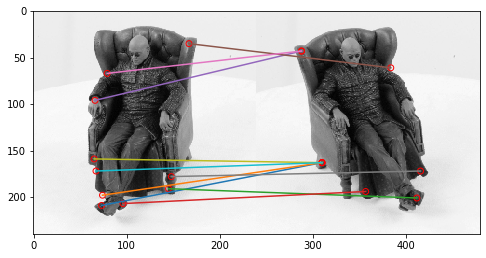

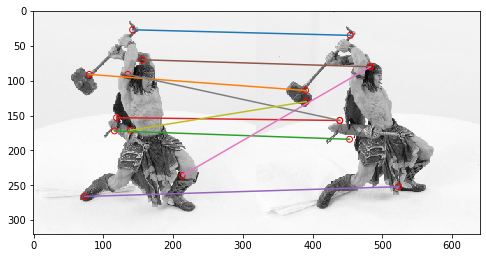

In [95]:
# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.savefig('dino_matching.png')
    plt.show()

print("Number of Corners:", nCorners)
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

nCorners: 10


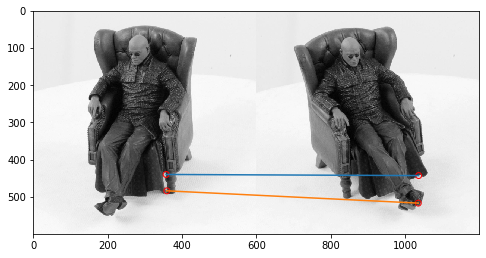

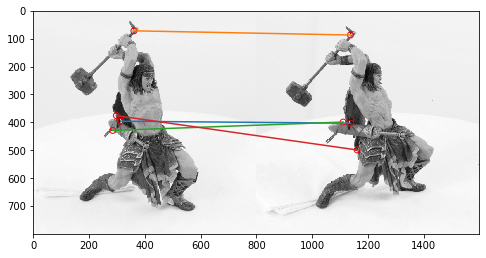

nCorners: 20


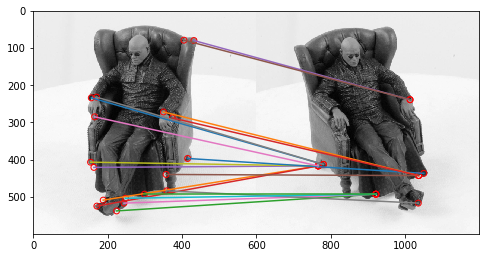

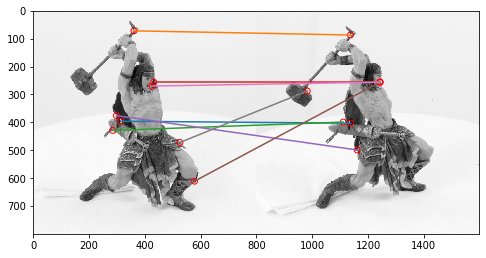

nCorners: 30


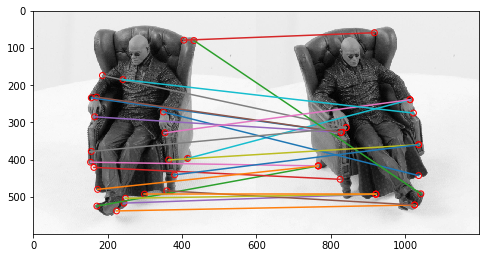

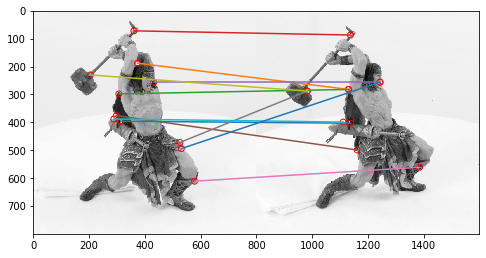

In [80]:
# =====================================================
# ALSO SHOW RESULTS FOR DIFFERENT # OF DETECTED CORNERS
# =====================================================
downSize = 2
for nCorners in (10, 20, 30):
    # read images and detect corners on images
    imgs_mat = []
    crns_mat = []
    imgs_war = []
    crns_war = []
    for i in range(2):
        img_mat = imageio.imread('p4/matrix/matrix' + str(i) + '.png')
        #imgs_mat.append(rgb2gray(img_mat))
        # downsize your image in case corner_detect runs slow in test
        imgs_mat.append(rgb2gray(img_mat)[::downSize, ::downSize])
        crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))

        img_war = imageio.imread('p4/warrior/warrior' + str(i) + '.png')
        #imgs_war.append(rgb2gray(img_war))
        imgs_war.append(rgb2gray(img_war)[::downSize, ::downSize])
        crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))

    # match corners
    R = 30 if nCorners != 30 else 20
    NCCth = 0.6
    matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
    matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)

    print('nCorners: %r' % nCorners)
    show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
    show_matching_result(imgs_war[0], imgs_war[1], matching_war)

### Epipolar Geometry (4 points)

Complete the <code>compute_fundamental</code> function below using the 8-point algorithm described in lecture. Using the <code>fundamental_matrix</code> function and the corresponding points provided in `cor1.npy` and `cor2.npy`, calculate the fundamental matrix for the `matrix` and `warrior` image sets. Note that the normalization of the corner points is handled in the <code>fundamental_matrix</code> function.

In [96]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.linalg import svd, eig

def compute_fundamental(x1, x2):
    """ Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        
        Construct the A matrix according to lecture
        and solve the system of equations for the entries of the fundamental matrix.

        Returns:
        Fundamental Matrix (3x3)
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    #x1 and x2 passed into here are (3,14) matrices, (3,M) actually
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
        
    # return your F matrix
    #need to find A to take SVD
    #Start w/ A1, take x1 to be x' and x2 to be x
    A = np.array([[ x1[0,0]*x2[0,0], x1[0,0]*x2[1,0], x1[0,0], x1[1,0]*x2[0,0], 
                    x1[1,0]*x2[1,0], x1[1,0], x2[0,0], x2[1,0], 1 ]])
    
    for i in range(1,x1.shape[1]):
        temp = np.array([[ x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i], x1[1,i]*x2[0,i], 
                x1[1,i]*x2[1,i], x1[1,i], x2[0,i], x2[1,i], 1 ]])
        A = np.concatenate((A,temp), axis=0)
    u,s,v=svd(np.transpose(A)@A)
    F = v[-1]
    F = F.reshape(3,3)
    
    #make rank 2, rank = number of non-zero singular values of F
    #since F has 3 singular values, make last one zero to make rank 2
    u, s, v = svd(F)
    s[2] = 0
    #now reconstruct F with the 2 remaingin non-zero svd's
    temp = np.zeros((3,3))
    temp[0,0], temp[1,1] = s[0],s[1]
    F = np.matmul( u, np.matmul(temp,v) )
    F = F/F[2,2]
    return F


def fundamental_matrix(x1,x2):
    # Normalization of the corner points is handled here
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

### Plot Epipolar Lines (5 points)

Using this fundamental matrix, plot the epipolar lines in both images for each image pair. For this part, you will want to complete the function <code>plot_epipolar_lines</code>. Show your result for matrix and warrior as exemplified by the figure below. 

![Dino Epipolar](fig/dinoEpi1.png)
![Dino Epipolar](fig/dinoEpi2.png)

Also complete the function to calculate the epipoles for a given fundamental matrix.

In [203]:
from numpy.linalg import svd, eig
def compute_epipole(F):
    """
    This function computes the epipoles for a given fundamental matrix.
    input:
      F --> fundamental matrix
    output:
      e1 --> corresponding epipole in image 1
      e2 --> epipole in image2
    """
    U,S,V = svd(F)
    e2 = V[-1]
    e2 = e2/e2[2]
    U,S,V = svd(np.transpose(F))
    e1 = V[-1]
    e1 = e1/e1[2]
    return e1, e2


def plot_epipolar_lines(img1, img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners
    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)
    """
    img1 = img1.astype(np.int)
    img2 = img2.astype(np.int)
    #use previously defined functions
    F = fundamental_matrix(cor1,cor2)
    e1, e2 = compute_epipole(F)
    
    fig= plt.figure(figsize = (10,10))
    plt.subplot(121)
    yL, xL, trash = img1.shape
    cor1 = np.transpose(cor1)
    for corner in cor1:
        slope = - (e1[1] - corner[1])/(e1[0] - corner[0])
        
        yInt = corner[1] + slope*corner[0]
        yEnd = -slope*xL + yInt
        x = [0, xL]
        y = [yInt, yEnd]
        
        plt.plot(x, y, 'b-')
        plt.plot([corner[0]], [corner[1]], 'bo')
    plt.imshow(img1)
    plt.xlim([0, xL])
    plt.ylim([yL, 0]) 
    plt.title('Image 1')
    
    #plt.show() 
    
    #fig= plt.figure(figsize = (6,6))
    plt.subplot(122)
    yL, xL, trash = img2.shape
    cor2 = np.transpose(cor2)
    for corner in cor2:
        slope = - (e2[1] - corner[1])/(e2[0] - corner[0])
        
        yInt = corner[1] + slope*corner[0]
        yEnd = -slope*xL + yInt
        x = [0, xL]
        y = [yInt, yEnd]
        
        plt.plot(x, y, 'b-')
        plt.plot([corner[0]], [corner[1]], 'bo')
    plt.imshow(img2)
    plt.xlim([0, xL])
    plt.ylim([yL, 0]) 
    plt.title('Image 2')
    plt.show() 
    
    return

dino


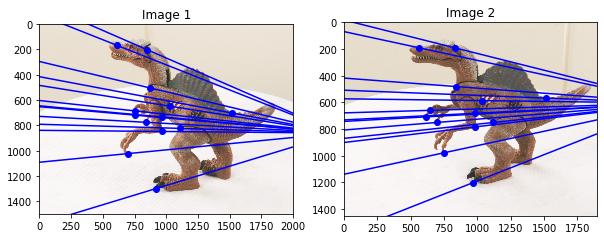



matrix


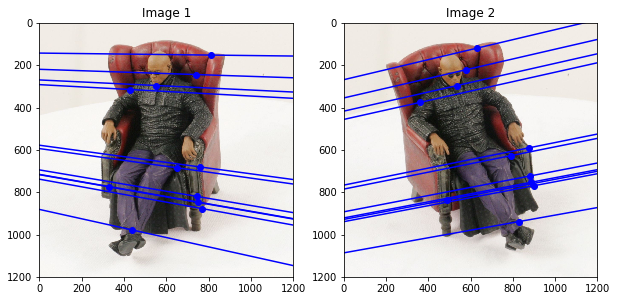



warrior


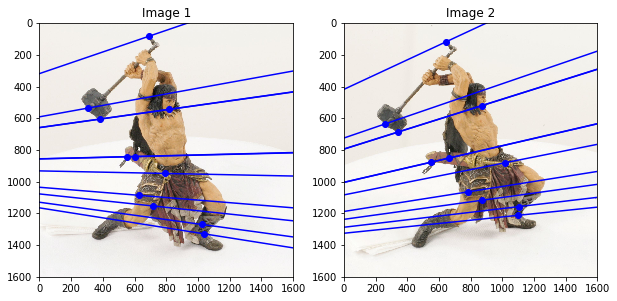

In [179]:
# replace images and corners with those of matrix and warrior

imgids = ["dino", "matrix", "warrior"]
for imgid in imgids:
    I1 = imageio.imread("./p4/"+imgid+"/"+imgid+"0.png")
    I2 = imageio.imread("./p4/"+imgid+"/"+imgid+"1.png")

    cor1 = np.load("./p4/"+imgid+"/cor1.npy")
    cor2 = np.load("./p4/"+imgid+"/cor2.npy")
    print(imgid)
    plot_epipolar_lines(I1,I2,cor1,cor2)
    print('\n')

### Image Rectification (5 points)

An interesting case for epipolar geometry occurs when two images are parallel to each other. In this case, there is no rotation component involved between the two images and the essential matrix is $\texttt{E}=[\boldsymbol{T_{x}}]\boldsymbol{R}=[\boldsymbol{T_{x}}]$. Also if you observe the epipolar lines $\boldsymbol{l}$ and $\boldsymbol{l^{'}}$ for parallel images, they are horizontal and consequently, the corresponding epipolar lines share the same vertical coordinate. Therefore the process of making images parallel becomes useful while discerning the relationships between corresponding points in images.
 
Rectifying a pair of images can also be done for uncalibrated camera images (i.e. we do not require the camera matrix of intrinsic parameters). Using the fundamental matrix we can find the pair of epipolar lines $\boldsymbol{l_i}$ and $\boldsymbol{l^{'}_i}$ for each of the correspondences. The intersection of these lines will give us the respective epipoles $\boldsymbol{e}$ and $\boldsymbol{e^{'}}$.  Now to make the epipolar lines to be parallel we need to map the epipoles to infinity. Hence, we need to find a homography that maps the epipoles to infinity.
 
The method to find the homography has already been implemented for you. You can read more about the method used to estimate the homography in the paper "Theory and Practice of Projective Rectification" by Richard Hartley.
![Image Rectification Setup](fig/image_rectification.png)

Using the `compute_epipole` function from the previous part and the given `compute_matching_homographies` function, find the rectified images and plot the parallel epipolar lines using the `plot_epipolar_lines` function from above. You need to do this for both the `matrix` and the `warrior` images. Below is an example of the output for this part:
![sample rectification](fig/Sample_rectification.png)

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import math


# convert points from euclidian to homogeneous
def to_homog(points):
    # write your code here
    check = np.shape(points)
    homog = np.ones((check[0]+1, check[1]))
    homog[0:check[0], 0:check[1]] = points[:,:]
    return(homog)


# convert points from homogeneous to euclidian
def from_homog(points_homog):
    # write your code here
    check = np.shape(points_homog)
    last_row = points_homog[check[0]-1, :]
    euclid = points_homog/last_row[None,:]
    euclid = euclid[0:check[0]-1, :]
    return(euclid)
'''

'''
def dist(source_image, H):
    target_size = source_image.shape
    target_img = 255*np.ones(target_size)
    
    
    
    for i in range(target_size[0]):
        for j in range(target_size[1]):
            
            
            newCoords = np.rint(from_homog(np.matmul(np.linalg.inv(H), to_homog(np.array([[i], [j]])))))
            
            #newCoords = np.rint(newCoords)
            
            xTarget, yTarget = int(newCoords[0]), int(newCoords[1])
            
            if xTarget >= 0 and xTarget < source_image.shape[1] and yTarget>=0 and yTarget<source_image.shape[0]:
                target_img[j,i,:]=source_image[yTarget,xTarget,:]
    
    
    return target_img

/Users/femw90/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


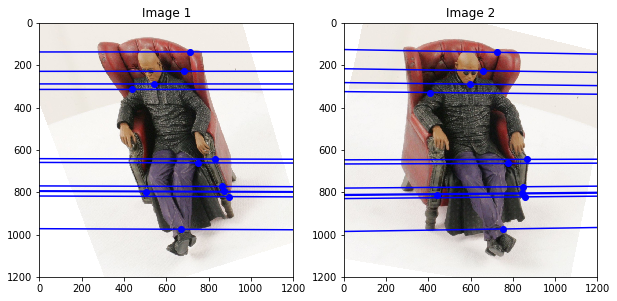

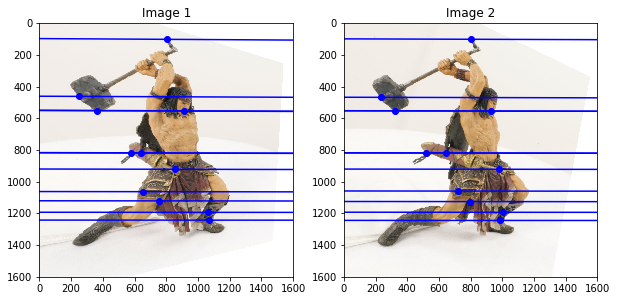

In [209]:
def compute_matching_homographies(e2, F, im2, points1, points2):
    """This function computes the homographies to get the rectified images.
    
    input:
      e2 --> epipole in image 2
      F --> the fundamental matrix (think about what you should be passing: F or F.T!)
      im2 --> image2
      points1 --> corner points in image1
      points2 --> corresponding corner points in image2
      
    output:
      H1 --> homography for image 1
      H2 --> homography for image 2
    """
    # calculate H2
    width = im2.shape[1]
    height = im2.shape[0]

    T = np.identity(3)
    T[0][2] = -1.0 * width / 2
    T[1][2] = -1.0 * height / 2

    e = T.dot(e2)
    e1_prime = e[0]
    e2_prime = e[1]
    if e1_prime >= 0:
        alpha = 1.0
    else:
        alpha = -1.0

    R = np.identity(3)
    R[0][0] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[0][1] = alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][0] = - alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][1] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)

    f = R.dot(e)[0]
    G = np.identity(3)
    G[2][0] = - 1.0 / f

    H2 = np.linalg.inv(T).dot(G.dot(R.dot(T)))

    # calculate H1
    e_prime = np.zeros((3, 3))
    e_prime[0][1] = -e2[2]
    e_prime[0][2] = e2[1]
    e_prime[1][0] = e2[2]
    e_prime[1][2] = -e2[0]
    e_prime[2][0] = -e2[1]
    e_prime[2][1] = e2[0]

    v = np.array([1, 1, 1])
    M = e_prime.dot(F) + np.outer(e2, v)

    points1_hat = H2.dot(M.dot(points1.T)).T
    points2_hat = H2.dot(points2.T).T

    W = points1_hat / points1_hat[:, 2].reshape(-1, 1)
    b = (points2_hat / points2_hat[:, 2].reshape(-1, 1))[:, 0]

    # least square problem
    a1, a2, a3 = np.linalg.lstsq(W, b)[0]
    HA = np.identity(3)
    HA[0] = np.array([a1, a2, a3])

    H1 = HA.dot(H2).dot(M)
    return H1, H2


def image_rectification(im1, im2, points1, points2):
    """This function provides the rectified images along with the new corner points as outputs for a given pair of 
    images with corner correspondences
    input:
    im1--> image1
    im2--> image2
    points1--> corner points in image1
    points2--> corner points in image2
    outpu:
    rectified_im1-->rectified image 1
    rectified_im2-->rectified image 2
    new_cor1--> new corners in the rectified image 1
    new_cor2--> new corners in the rectified image 2
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    '''
    #need epipole and fundamental matrix
    F = fundamental_matrix(points1,points2)
    e1, e2 = compute_epipole(F)
    e1 = e1 / e1[-1]
    e2 = e2 / e2[-1]
    H1, H2 = compute_matching_homographies(e2, np.transpose(F), im2, points1.T, points2.T)
    
    
    rectified_im2 = im2
    rectified_im1 = im1
    
    
    new_cor2 = H2@points2
    new_cor1 = H1@points1
    #print(new_cor1)
    #print(new_cor2)
    new_cor1 = new_cor1/new_cor1[-1]
    new_cor2 = new_cor2/new_cor2[-1]
    #print(new_cor1)
    #print(new_cor2)
    
    sz = np.shape(im1)
    
    #targetSizeX, targetSizeY = target_size[0], target_size[1]
    #target_img = np.ones((targetSizeX,targetSizeY,3))
    '''
    
    F = fundamental_matrix(points1,points2)
    e1, e2 = compute_epipole(F)
    e1 = e1 / e1[-1]
    e2 = e2 / e2[-1]
    H1, H2 = compute_matching_homographies(e2, np.transpose(F), im2, points1.T, points2.T)
    
    check1 = H1@e1
    check2 = H2@e2
    
    new_cor2 = H2@points2
    new_cor1 = H1@points1
    new_cor1 = new_cor1/new_cor1[-1]
    new_cor2 = new_cor2/new_cor2[-1]
    rectified_im1 = dist(im1, H1)
    rectified_im2 = dist(im2, H2)
    
    return rectified_im1, rectified_im2, new_cor1, new_cor2


# Plot the parallel epipolar lines using plot_epipolar_lines
for subj in ('matrix', 'warrior'):
    I1 = imread("./p4/%s/%s0.png" % (subj, subj))
    I2 = imread("./p4/%s/%s1.png" % (subj, subj))

    cor1 = np.load("./p4/%s/cor1.npy" % subj)
    cor2 = np.load("./p4/%s/cor2.npy" % subj)

    rectified_im1, rectified_im2, new_cor1, new_cor2 = image_rectification(I1, I2, cor1, cor2)
    plot_epipolar_lines(rectified_im1, rectified_im2, new_cor1, new_cor2)

### Matching Using Epipolar Geometry (4 points)

We will now use the epipolar geometry constraint on the rectified images and updated corner points to build a better matching algorithm. First, detect 10 corners in image1. Then, for each corner, do a line search along the corresponding parallel epipolar line in image2.

Evaluate the NCC score for each point along this line and return the best match (or no match if all
scores are below the NCCth). R is the radius (size) of the NCC patch in the code below.

You do not have to run this in both directions. Show your result as in the naive matching part. Execute this process for the `warrior` and `matrix` image sets. **In total, you should have two output images for this part.**

In [223]:
# plot matching result
def show_matching_result(img1, img2, matching):
    img1 = img1.astype(np.int)
    img2 = img2.astype(np.int)
    fig = plt.figure(figsize=(8, 8))
    #plt.imshow(np.hstack((img1, img2)), cmap='gray')
    plt.imshow(np.hstack((img1, img2)).astype(np.int), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.savefig('dino_matching.png')
    plt.show()

In [224]:
def display_correspondence(img1, img2, corrs):
    """Plot matching result on image pair given images and correspondences

    Args:
        img1: Image 1.
        img2: Image 2.
        corrs: Corner correspondence
    """
    
    """ ==========
    YOUR CODE HERE
    You may want to refer to the `show_matching_result` function.
    ========== """
    img1 = img1.astype(np.int)
    img2 = img2.astype(np.int)
    show_matching_result(img1, img2, corrs)

def correspondence_matching_epipole(img1, img2, corners1, F, R, NCCth):
    """Find corner correspondence along epipolar line.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Detected corners in image 1.
        F: Fundamental matrix calculated using given ground truth corner correspondences.
        R: NCC matching window radius.
        NCCth: NCC matching threshold.
    
    Returns:
        Matching result to be used in display_correspondence function
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    matching = []
    for corner in corners1:
        vertConst = corner[1]
        currentScore = 0
        for j in range( R, np.shape(img2)[1]-R):
            checkPoint = np.zeros_like(corner)
            checkPoint[0], checkPoint[1] = j, vertConst
            newScore = ncc_match(img1, img2, corner, checkPoint, R)
            if newScore > currentScore:
                currentScore = newScore
                matchTup = (corner, checkPoint)
        if currentScore >= NCCth:
            matching.append(matchTup)
        a=1
    print(matching)
    return matching

    
    

/Users/femw90/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[(array([ 682., 1023.]), array([ 731., 1023.])), (array([ 753., 1050.]), array([ 827., 1050.])), (array([376., 520.]), array([297., 520.])), (array([878., 797.]), array([855., 797.])), (array([ 676., 1009.]), array([ 725., 1009.])), (array([940., 706.]), array([900., 706.])), (array([757., 972.]), array([976., 972.])), (array([844., 930.]), array([868., 930.])), (array([392., 381.]), array([311., 381.])), (array([667., 989.]), array([487., 989.]))]


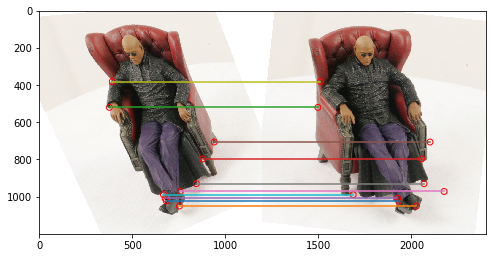

[(array([681., 766.]), array([690., 766.])), (array([1074., 1089.]), array([1208., 1089.])), (array([681., 781.]), array([685., 781.])), (array([637., 723.]), array([656., 723.])), (array([970., 528.]), array([969., 528.])), (array([960., 890.]), array([929., 890.])), (array([ 811., 1007.]), array([ 375., 1007.])), (array([854., 393.]), array([878., 393.])), (array([629., 755.]), array([644., 755.])), (array([679., 567.]), array([712., 567.]))]


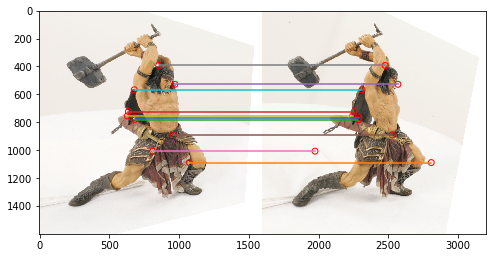

In [225]:
I1 = imageio.imread("./p4/matrix/matrix0.png")
I2 = imageio.imread("./p4/matrix/matrix1.png")
cor1 = np.load("./p4/matrix/cor1_alt.npy")
cor2 = np.load("./p4/matrix/cor2_alt.npy")
I3 = imageio.imread("./p4/warrior/warrior0.png")
I4 = imageio.imread("./p4/warrior/warrior1.png")
cor3 = np.load("./p4/warrior/cor1.npy")
cor4 = np.load("./p4/warrior/cor2.npy")
'''
downSize = 10
cor1 = np.round(cor1/downSize)
cor2 = np.round(cor2/downSize)
cor3 = np.round(cor3/downSize)
cor4 = np.round(cor4/downSize)
I1 = I1[::downSize, ::downSize]
I2 = I2[::downSize, ::downSize]
I3 = I3[::downSize, ::downSize]
I4 = I4[::downSize, ::downSize]
'''
# For matrix
rectified_im1, rectified_im2, new_cor1, new_cor2 = image_rectification(I1, I2, cor1, cor2)
F_new = fundamental_matrix(new_cor1, new_cor2)
# replace black pixels with white pixels
_black_idxs = (rectified_im1[:, :, 0] == 0) & (rectified_im1[:, :, 1] == 0) & (rectified_im1[:, :, 2] == 0)
rectified_im1[:, :][_black_idxs] = [1.0, 1.0, 1.0]
_black_idxs = (rectified_im2[:, :, 0] == 0) & (rectified_im2[:, :, 1] == 0) & (rectified_im2[:, :, 2] == 0)
rectified_im2[:, :][_black_idxs] = [1.0, 1.0, 1.0]

nCorners = 10

# Choose your threshold and NCC matching window radius
NCCth = 0.6
R = 90

# detect corners using corner detector here, store in corners1
corners1 = corner_detect(rgb2gray(rectified_im1), nCorners, smoothSTD, windowSize)
corrs = correspondence_matching_epipole(rectified_im1, rectified_im2, corners1, F_new, R, NCCth)
display_correspondence(rectified_im1, rectified_im2, corrs)





# For warrior
rectified_im3, rectified_im4, new_cor3, new_cor4 = image_rectification(I3, I4, cor3, cor4)
F_new2 = fundamental_matrix(new_cor3, new_cor4)

# replace black pixels with white pixels
_black_idxs = (rectified_im3[:, :, 0] == 0) & (rectified_im3[:, :, 1] == 0) & (rectified_im3[:, :, 2] == 0)
rectified_im3[:, :][_black_idxs] = [1.0, 1.0, 1.0]
_black_idxs = (rectified_im4[:, :, 0] == 0) & (rectified_im4[:, :, 1] == 0) & (rectified_im4[:, :, 2] == 0)
rectified_im4[:, :][_black_idxs] = [1.0, 1.0, 1.0]

# You may wish to change your NCCth and R for warrior here.
NCCth = 0.6
R = 90

corners2 = corner_detect(rgb2gray(rectified_im3), nCorners, smoothSTD, windowSize)
corrs = correspondence_matching_epipole(rectified_im3, rectified_im4, corners2, F_new2, R, NCCth)
display_correspondence(rectified_im3, rectified_im4, corrs)

/Users/femw90/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[(array([ 682., 1023.]), array([ 507., 1023.])), (array([ 753., 1050.]), array([ 808., 1050.])), (array([376., 520.]), array([297., 520.])), (array([878., 797.]), array([857., 797.])), (array([ 676., 1009.]), array([ 502., 1009.])), (array([940., 706.]), array([897., 706.])), (array([757., 972.]), array([802., 972.])), (array([844., 930.]), array([870., 930.])), (array([392., 381.]), array([316., 381.])), (array([667., 989.]), array([493., 989.]))]


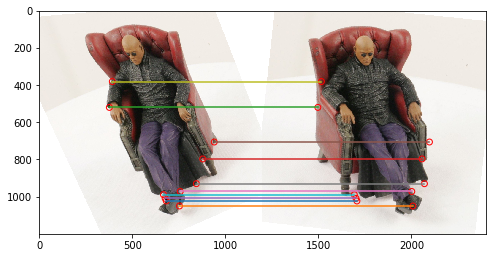

[(array([681., 766.]), array([698., 766.])), (array([1074., 1089.]), array([1054., 1089.])), (array([681., 781.]), array([687., 781.])), (array([637., 723.]), array([660., 723.])), (array([970., 528.]), array([971., 528.])), (array([960., 890.]), array([931., 890.])), (array([ 811., 1007.]), array([ 579., 1007.])), (array([854., 393.]), array([878., 393.])), (array([629., 755.]), array([650., 755.])), (array([679., 567.]), array([716., 567.]))]


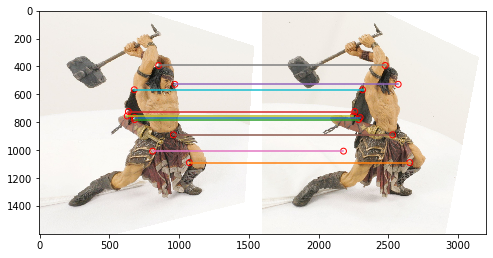

In [226]:
I1 = imageio.imread("./p4/matrix/matrix0.png")
I2 = imageio.imread("./p4/matrix/matrix1.png")
cor1 = np.load("./p4/matrix/cor1_alt.npy")
cor2 = np.load("./p4/matrix/cor2_alt.npy")
I3 = imageio.imread("./p4/warrior/warrior0.png")
I4 = imageio.imread("./p4/warrior/warrior1.png")
cor3 = np.load("./p4/warrior/cor1.npy")
cor4 = np.load("./p4/warrior/cor2.npy")
'''
downSize = 10
cor1 = np.round(cor1/downSize)
cor2 = np.round(cor2/downSize)
cor3 = np.round(cor3/downSize)
cor4 = np.round(cor4/downSize)
I1 = I1[::downSize, ::downSize]
I2 = I2[::downSize, ::downSize]
I3 = I3[::downSize, ::downSize]
I4 = I4[::downSize, ::downSize]
'''
# For matrix
rectified_im1, rectified_im2, new_cor1, new_cor2 = image_rectification(I1, I2, cor1, cor2)
F_new = fundamental_matrix(new_cor1, new_cor2)
# replace black pixels with white pixels
_black_idxs = (rectified_im1[:, :, 0] == 0) & (rectified_im1[:, :, 1] == 0) & (rectified_im1[:, :, 2] == 0)
rectified_im1[:, :][_black_idxs] = [1.0, 1.0, 1.0]
_black_idxs = (rectified_im2[:, :, 0] == 0) & (rectified_im2[:, :, 1] == 0) & (rectified_im2[:, :, 2] == 0)
rectified_im2[:, :][_black_idxs] = [1.0, 1.0, 1.0]

nCorners = 10

# Choose your threshold and NCC matching window radius
NCCth = 0.6
R = 120

# detect corners using corner detector here, store in corners1
corners1 = corner_detect(rgb2gray(rectified_im1), nCorners, smoothSTD, windowSize)
corrs = correspondence_matching_epipole(rectified_im1, rectified_im2, corners1, F_new, R, NCCth)
display_correspondence(rectified_im1, rectified_im2, corrs)





# For warrior
rectified_im3, rectified_im4, new_cor3, new_cor4 = image_rectification(I3, I4, cor3, cor4)
F_new2 = fundamental_matrix(new_cor3, new_cor4)

# replace black pixels with white pixels
_black_idxs = (rectified_im3[:, :, 0] == 0) & (rectified_im3[:, :, 1] == 0) & (rectified_im3[:, :, 2] == 0)
rectified_im3[:, :][_black_idxs] = [1.0, 1.0, 1.0]
_black_idxs = (rectified_im4[:, :, 0] == 0) & (rectified_im4[:, :, 1] == 0) & (rectified_im4[:, :, 2] == 0)
rectified_im4[:, :][_black_idxs] = [1.0, 1.0, 1.0]

# You may wish to change your NCCth and R for warrior here.
NCCth = 0.6
R = 120

corners2 = corner_detect(rgb2gray(rectified_im3), nCorners, smoothSTD, windowSize)
corrs = correspondence_matching_epipole(rectified_im3, rectified_im4, corners2, F_new2, R, NCCth)
display_correspondence(rectified_im3, rectified_im4, corrs)

---

### Submission Instructions

Remember to submit a PDF version of this notebook to Gradescope. You can create a PDF via **File > Download as > PDF via LaTeX** (preferred, if possible), or by downloading as an HTML page and then "printing" the HTML page to a PDF (by opening the print dialog and then choosing the "Save as PDF" option).